# Predicting All-NBA Team and Player Salaries - Modeling Part II of II: Player Salaries
---

In our modeling notebooks, we will build upon the groundwork laid by our webscraping, data cleaning, and exploratory data analysis. Our cleaned data now contains over 80 features, including player statistic (advanced, totals, and per-game), salary cap information, and team payroll data. With this, our objective is twofold:

1. <u>**All-NBA Team**</u>: In our previous notebook ([Part I](./04_Data_Modeling_I.ipynb)), we ...

    1. Constructed multiple <u>**regression models**</u> to predict voter share, which ultimately enabled us to discern which Top 15 players made the All-NBA Teams (5 per 1st, 2nd, and 3rd Teams). 
    2. Briefly employed <u>**classification models**</u> to determine how well our models performed in deciphering between 1st, 2nd, and 3rd team players. 
    <br></br>
2. <span style = 'color:orange'><u>**Salary**</u>:</span> Next, in this notebook, we will also use <u>**regression modeling**</u> to predict player salaries, training on the intricate relationship between player performance, individual statistics, and their contracts. 

This process will involve trial and error as well as the application of GridSearch techniques to fine-tune our models.

At the end of our analysis, we hope to unravel the complexities of the NBA landscape, discovering patterns and associations that govern player recognition in All-NBA Teams and their financial remuneration. These insights will inform decision-making processes and aid in the evaluation of player performance and compensation within the competitive realm of professional basketball.

Further detailed notebooks on the various segments of this project can be found at the following: 
- [01_Data_Acquisition](./01_Data_Acquisition.ipynb)
- [02_Data_Cleaning](./02_Data_Cleaning.ipynb)
- [03_Preliminary_EDA](./03_Preliminary_EDA.ipynb)
- [04_Data_Modeling_I](./04_Data_Modeling_I.ipynb)

For more information on the background, a summary of methods, and findings, please see the associated [README](../README.md) for this analysis.

## Contents

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import shap
import streamlit as st


from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, VotingRegressor, AdaBoostRegressor, GradientBoostingRegressor
# LGBMRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# from sklearn.compose import ColumnTransformer
# from sklearn.neighbors import KNeighborsClassifier

import datetime

import warnings
warnings.filterwarnings('ignore') 

pd.options.display.max_rows = 400
pd.options.display.max_columns = 400

In [2]:
df = pd.read_csv('../data/clean/stats_main.csv')
df.head()

,player,pos,age,tm,g,pg_gs,pg_mp,pg_fg,pg_fga,pg_fg%,pg_3p,pg_3pa,pg_3p%,pg_2p,pg_2pa,pg_2p%,pg_efg%,pg_ft,pg_fta,pg_ft%,pg_orb,pg_drb,pg_trb,pg_ast,pg_stl,pg_blk,pg_tov,pg_pf,pg_pts,year,tot_gs,tot_mp,tot_fg,tot_fga,tot_fg%,tot_3p,tot_3pa,tot_3p%,tot_2p,tot_2pa,tot_2p%,tot_efg%,tot_ft,tot_fta,tot_ft%,tot_orb,tot_drb,tot_trb,tot_ast,tot_stl,tot_blk,tot_tov,tot_pf,tot_pts,adv_per,adv_ts%,adv_3par,adv_ftr,adv_orb%,adv_drb%,adv_trb%,adv_ast%,adv_stl%,adv_blk%,adv_tov%,adv_usg%,adv_ows,adv_dws,adv_ws,adv_ws/48,adv_obpm,adv_dbpm,adv_bpm,adv_vorp,gt1_pos,pos_5,pos_3,f,gu,midseason_trade,all_nba_team,pts_won,pts_max,share,all_nba_winner,n_allstar,all_star,salary,salary_adj,team,conf,div,w,l,w/l%,seed,champs,won_championship,salary_cap,salary_cap_adj,payroll,payroll_adj
0,Nick Anderson,SG,23,ORL,70,42.0,28,5.7,12.2,0.467,0.2,0.8,0.293,5.5,11.4,0.479,0.477,2.5,3.7,0.668,1.3,4.2,5.5,1.5,1.1,0.6,1.6,2.1,14.1,1990,42.0,1971,400.0,857.0,0.467,17.0,58.0,0.293,383.0,799.0,0.479,0.477,173.0,259.0,0.668,92.0,294.0,386.0,106.0,74.0,44.0,113.0,145.0,990.0,15.1,0.510,0.068,0.302,4.9,16.7,10.7,8.5,1.8,1.3,10.4,22.4,1.2,1.9,3.1,0.075,0.0,0.3,0.3,1.1,0,SG,Gu,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0,725000.0,1653775.0,Orlando Magic,W,M,31,51,0.378,19,Chicago Bulls,0,11871000.0,25499592.0,7532000.0,17181014.0
1,Ron Anderson,SF,32,PHI,82,13.0,28,6.2,12.9,0.485,0.1,0.5,0.209,6.1,12.3,0.497,0.490,2.0,2.4,0.833,1.3,3.2,4.5,1.4,0.8,0.2,1.2,2.0,14.6,1990,13.0,2340,512.0,1055.0,0.485,9.0,43.0,0.209,503.0,1012.0,0.497,0.490,165.0,198.0,0.833,103.0,264.0,367.0,115.0,65.0,13.0,100.0,163.0,1198.0,15.5,0.524,0.041,0.188,5.0,12.4,8.8,8.2,1.4,0.3,8.1,23.2,2.3,1.8,4.1,0.085,-0.2,-1.4,-1.6,0.2,0,SF,F,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0,425000.0,969454.0,Philadelphia 76ers,E,A,44,38,0.537,12,Chicago Bulls,0,11871000.0,25499592.0,11640000.0,26551652.0
2,Willie Anderson,SG,24,SAS,75,75.0,34,6.0,13.2,0.457,0.1,0.5,0.200,5.9,12.7,0.467,0.461,2.3,2.8,0.798,0.9,3.8,4.7,4.8,1.1,0.6,2.2,3.0,14.4,1990,75.0,2592,453.0,991.0,0.457,7.0,35.0,0.200,446.0,956.0,0.467,0.461,170.0,213.0,0.798,68.0,283.0,351.0,358.0,79.0,46.0,167.0,226.0,1083.0,13.0,0.499,0.035,0.215,3.1,11.5,7.5,20.2,1.5,1.1,13.3,20.1,1.3,3.5,4.8,0.089,-0.9,1.0,0.1,1.4,0,SG,Gu,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0,725000.0,1653775.0,San Antonio Spurs,W,M,55,27,0.671,6,Chicago Bulls,0,11871000.0,25499592.0,11057000.0,25221786.0
3,Thurl Bailey,PF,29,UTA,82,22.0,30,4.9,10.6,0.458,0.0,0.0,0.000,4.9,10.6,0.459,0.458,2.7,3.3,0.808,1.2,3.7,5.0,1.5,0.6,1.1,1.6,2.0,12.4,1990,22.0,2486,399.0,872.0,0.458,0.0,3.0,0.000,399.0,869.0,0.459,0.458,219.0,271.0,0.808,101.0,306.0,407.0,124.0,53.0,91.0,130.0,160.0,1017.0,12.5,0.513,0.003,0.311,5.1,13.6,9.6,7.7,1.1,2.3,11.6,20.0,0.6,3.1,3.7,0.072,-1.4,0.0,-1.4,0.4,0,PF,F,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0,1000000.0,2281070.0,Utah Jazz,W,M,54,28,0.659,7,Chicago Bulls,0,11871000.0,25499592.0,10695000.0,24396040.0
4,Benoit Benjamin,C,26,LAC,70,65.0,31,5.5,11.1,0.496,0.0,0.0,0.000,5.5,11.1,0.496,0.496,3.0,4.2,0.712,2.2,8.1,10.3,1.7,0.8,2.1,3.4,2.6,14.0,1990,65.0,2236,386.0,778.0,0.496,0.0,0.0,0.000,386.0,778.0,0.496,0.496,210.0,295.0,0.712,157.0,566.0,723.0,119.0,54.0,145.0,235.0,184.0,982.0,15.1,0.541,0.000,0.379,7.8,28.7,18.1,7.7,1.2,4.0,20.6,21.0,-0.7,3.7,3.0,0.064,-1.9,0.8,-1.1,0.5,0,C,C,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0,1750000.0,3991872.0,Los Angeles Clippers,W,P,31,51,0.378,18,Chicago Bulls,0,11871000.0,25499592.0,10245000.0,23369557.0


In [3]:
df.shape

(4377, 102)

In [4]:
train_yrs = [i for i in range(1990, 2017)] #1990-2016
test_yrs = [i for i in range(2017,2021)] #2017-2020
hold_yrs = [2021, 2022] 

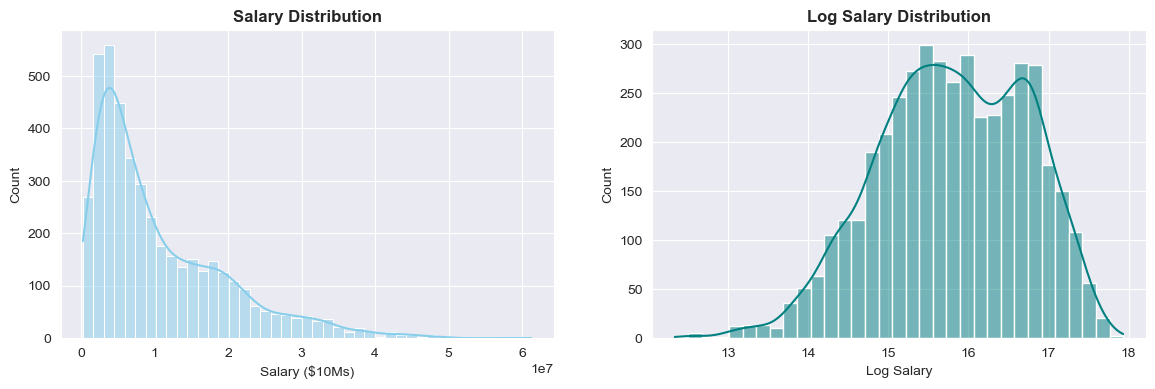

In [5]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1,2,figsize=(14,4))
sns.histplot(data=df, x="salary_adj", kde=True, color="skyblue", ax=ax[0]);
ax[0].set_title('Salary Distribution', fontweight='bold')
ax[0].set_xlabel('Salary ($10Ms)')

df['log_sal'] = np.log(df.salary_adj)
sns.histplot(data=df, x="log_sal", kde=True, color="teal", ax=ax[1]);
ax[1].set_title('Log Salary Distribution', fontweight='bold')
ax[1].set_xlabel('Log Salary');

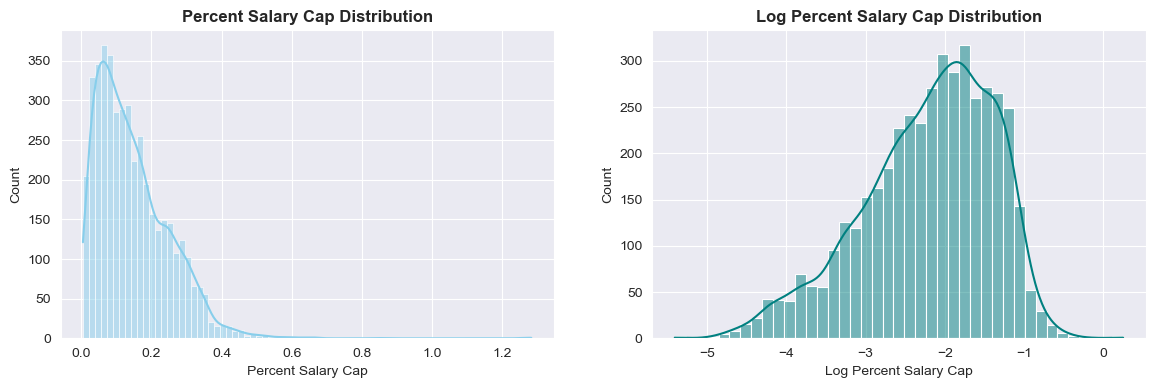

In [6]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
df['pct_cap'] = df.salary_adj / df.salary_cap_adj 
sns.histplot(data=df, x="pct_cap", kde=True, color="skyblue", ax=ax[0]);
ax[0].set_title('Percent Salary Cap Distribution', fontweight='bold')
ax[0].set_xlabel('Percent Salary Cap')

df['pct_cap_log'] = np.log(df.pct_cap)
sns.histplot(data=df, x="pct_cap_log", kde=True, color="teal", ax=ax[1]);
ax[1].set_title('Log Percent Salary Cap Distribution', fontweight='bold')
ax[1].set_xlabel('Log Percent Salary Cap');

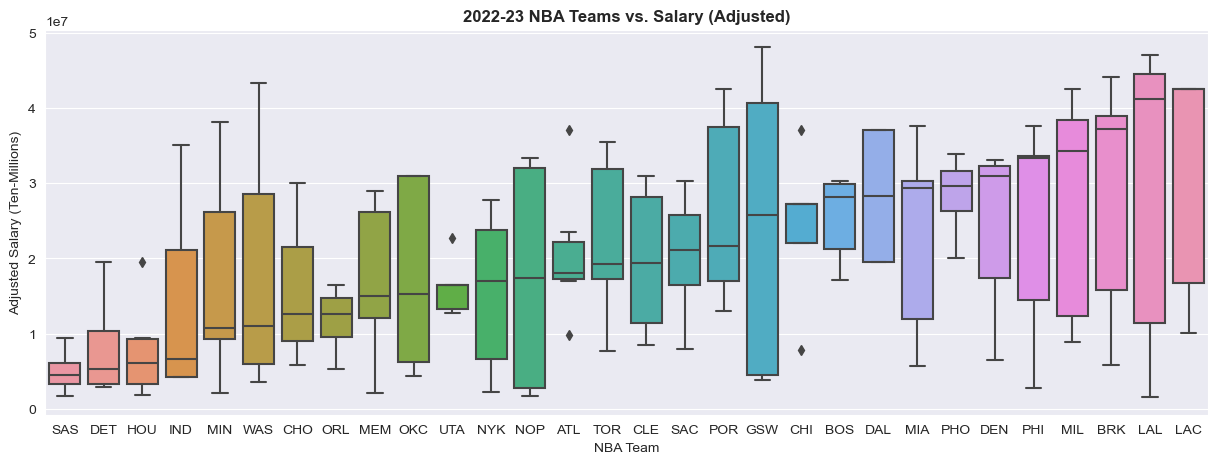

In [7]:
sns.set_style('darkgrid')
              
thirty_yrs = df[df.year == 1992]
twenty_yrs = df[df.year == 2002]
ten_yrs = df[df.year == 2012]
current = df[df.year == 2022]

def tmsals(dyrs, yrs):
    fig, ax = plt.subplots(1,1, figsize = (15,5))
    sorted_teams = dyrs.groupby('tm')['salary_adj'].median().sort_values().index
    sns.boxplot(data=dyrs, x='tm', y='salary_adj', order = sorted_teams)
    
    plt.title(f'{yrs} NBA Teams vs. Salary (Adjusted)', fontweight='bold')
    plt.xlabel('NBA Team')
    plt.ylabel('Adjusted Salary (Ten-Millions)')
    return plt.show()
    
tmsals(current, "2022-23")

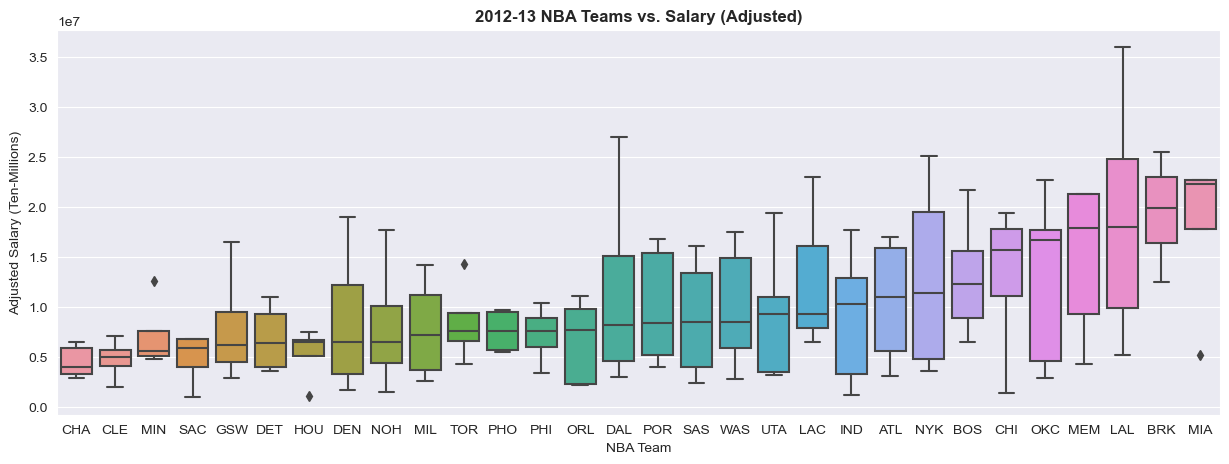

In [8]:
tmsals(ten_yrs, "2012-13")

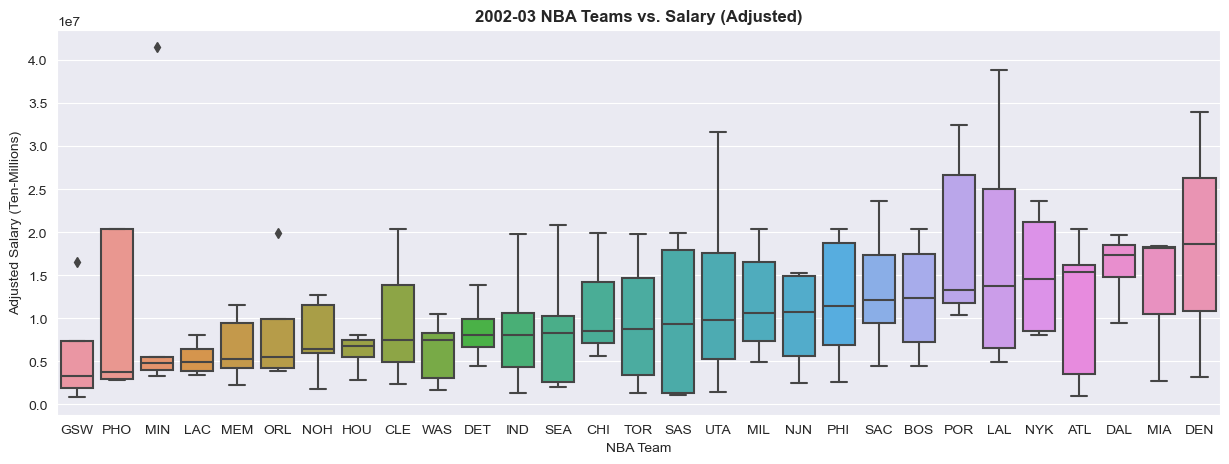

In [9]:
tmsals(twenty_yrs, "2002-03")

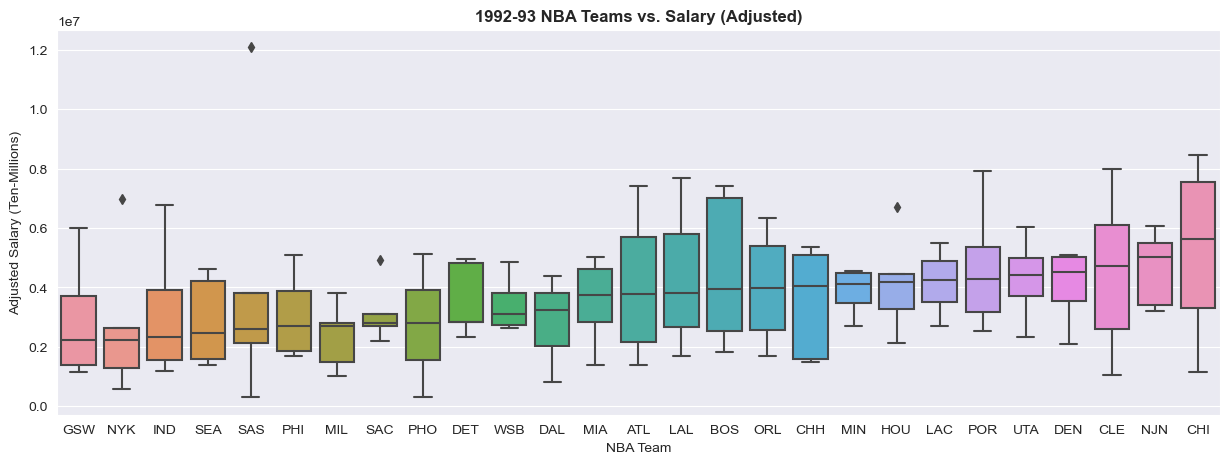

In [10]:
tmsals(thirty_yrs, "1992-93")

In [11]:
# We have dummified Position into 3 Positions for All-NBA voting (G, F, C) - here it is more appropriate to dummify by the standard 5 positions (PG, SG, SF, PF, C)
df = pd.get_dummies(df, columns = ['pos_5'], prefix = 'pos5', drop_first=True)

In [12]:
feats = ['age', 'g', 'pg_gs', 'pg_mp', 'pg_fg', 'pg_fga', 'pg_fg%', 'pg_3p', 'pg_3pa', 'pg_3p%', 'pg_2p', 'pg_2pa', 'pg_2p%', 'pg_efg%', 'pg_ft', 'pg_fta', 'pg_ft%', 'pg_orb', 'pg_drb', 'pg_trb', 'pg_ast', 'pg_stl', 'pg_blk', 'pg_tov', 'pg_pf', 'pg_pts', 'tot_mp', 'tot_fg%', 'tot_3p', 'tot_3p%', 'tot_2p%', 'tot_efg%', 'tot_ft%', 'tot_pf', 'tot_pts', 'adv_per', 'adv_ts%', 'adv_3par', 'adv_ftr', 'adv_orb%', 'adv_drb%', 'adv_trb%', 'adv_ast%', 'adv_stl%', 'adv_blk%', 'adv_tov%', 'adv_usg%', 'adv_ows', 'adv_dws', 'adv_ws', 'adv_ws/48', 'adv_obpm', 'adv_dbpm', 'adv_bpm', 'adv_vorp', 'w/l%', 'seed', 'all_star', 'pos5_PG', 'pos5_SG', 'pos5_SF', 'pos5_PF', 'year', 'salary_cap_adj']

In [13]:
X_train = df[feats].loc[df.year.isin(train_yrs)].reset_index(drop=True)
X_test = df[feats].loc[df.year.isin(test_yrs)].reset_index(drop=True)
X_hold = df[feats].loc[df.year.isin(hold_yrs)].reset_index(drop=True)

In [14]:
b1 = "\033[1m"
b0 = "\033[0m"

In [15]:
y_train = df['salary_adj'].loc[df.year.isin(train_yrs)]

null_mod = y_train.mean() # Overall mean in training data
null_mse = np.mean((y_train - null_mod)**2)
null_pred = np.full_like(y_train, y_train.mean())

print(f'---- OPTION 1: Predicting Salary ----')
print(f'Null Model: {round(null_mod,4)}')
print(f'Null MSE: {round(null_mse,4)}')
print(f'Null R^2: {round(r2_score(y_train, null_pred),4)}')

---- OPTION 1: Predicting Salary ----
Null Model: 9029655.4029
Null MSE: 53627753578441.43
Null R^2: 0.0


In [16]:
avg_sal_per_season = df.groupby('year')['salary_adj'].mean().reset_index().rename(columns={'salary_adj': 'mean_salary'})
null_mod = avg_sal_per_season.mean_salary.mean() # Mean of mean voter share per season
null_mse = np.mean((y_train - null_mod)**2)
null_pred = np.full_like(y_train, null_mod)

print(f'---- OPTION 2: Predicting Salary ----')
print(f'Null Model: {round(null_mod,4)}')
print(f'Null MSE: {round(null_mse,4)}')
print(f'Null R^2: {round(r2_score(y_train, null_pred),4)}')

---- OPTION 2: Predicting Salary ----
Null Model: 10555689.703
Null MSE: 55956534263459.55
Null R^2: -0.0434


In [17]:
y_train = df['pct_cap'].loc[df.year.isin(train_yrs)]

null_mod = y_train.mean() # Overall mean in training data
null_mse = np.mean((y_train - null_mod)**2)
null_pred = np.full_like(y_train, y_train.mean())

print(f'---- OPTION 1: Predicting Salary ----')
print(f'Null Model: {round(null_mod,4)}')
print(f'Null MSE: {round(null_mse,4)}')
print(f'Null R^2: {round(r2_score(y_train, null_pred),4)}')

---- OPTION 1: Predicting Salary ----
Null Model: 0.1452
Null MSE: 0.0108
Null R^2: 0.0


In [18]:
avg_pctcap_per_season = df.groupby('year')['pct_cap'].mean().reset_index().rename(columns={'pct_cap': 'mean_pct_cap'})
null_mod = avg_pctcap_per_season.mean_pct_cap.mean() # Mean of mean voter share per season
null_mse = np.mean((y_train - null_mod)**2)
null_pred = np.full_like(y_train, null_mod)

print(f'---- OPTION 2: Predicting Salary ----')
print(f'Null Model: {round(null_mod,4)}')
print(f'Null MSE: {round(null_mse,4)}')
print(f'Null R^2: {round(r2_score(y_train, null_pred),4)}')

---- OPTION 2: Predicting Salary ----
Null Model: 0.146
Null MSE: 0.0108
Null R^2: -0.0001


##### <span style = 'color:mediumvioletred' > _The null models are very poor at predicting salary. There will likely be a decent amount of variance and nuance in what exactly decides player salary, however, our model will be predicting salary based purely on statistics related to performance, as well as age and general information about the limits of payroll. We will use this to determine over- vs. under-valued players._

## Linear Regression

In [19]:
def mod_sal(features, yvar, mod):
    
    y_train = df[yvar].loc[df.year.isin(train_yrs)]
    y_test = df[yvar].loc[df.year.isin(test_yrs)]
    y_hold = df[yvar].loc[df.year.isin(hold_yrs)]
    
    mod.fit(X_train, y_train)
    
    y_preds = mod.predict(X_test)
    MSE = mean_squared_error(y_test, y_preds)
    RMSE = mean_squared_error(y_test, y_preds, squared=False)
        
    for i, coef in zip(X_train.columns, mod.coef_):
        print(f"{i}: {coef}")
    print(f"intercept: {mod.intercept_}")
    
    return print(f"\n{b1}Training R2:{b0} {mod.score(X_train, y_train)}, \n{b1}Testing R2:{b0} {mod.score(X_test, y_test)}, \n{b1}MSE:{b0} {MSE}, \n{b1}RMSE:{b0} {RMSE}")
    
mod_sal(feats, 'pct_cap', LinearRegression())

age: 0.01062758115396343
g: 0.00044935469852588634
pg_gs: 0.0003588462889484769
pg_mp: 0.0019602210202153314
pg_fg: -0.009332960555892457
pg_fga: 0.0448468901460417
pg_fg%: -0.7737348314810594
pg_3p: 0.03287717031955329
pg_3pa: -0.012061811338502036
pg_3p%: -0.006153815055053316
pg_2p: 0.05607086842298373
pg_2pa: -0.028975626758665038
pg_2p%: 0.015856749710436848
pg_efg%: 0.8189572372824702
pg_ft: -0.006814259195175691
pg_fta: 0.017656481749195596
pg_ft%: 0.021613931314302916
pg_orb: -0.0490927685036285
pg_drb: 0.006341869212697665
pg_trb: 0.009862859563152204
pg_ast: 0.003981201344339833
pg_stl: -0.023315251525929274
pg_blk: 0.0038557163854092357
pg_tov: 0.002283273350924847
pg_pf: 0.026764089235887707
pg_pts: -0.03160866568012435
tot_mp: -3.329027795095918e-06
tot_fg%: -0.7737347882105455
tot_3p: -0.0002237835855565251
tot_3p%: -0.006153803288206969
tot_2p%: 0.01585691836078852
tot_efg%: 0.818957108108948
tot_ft%: 0.02161391037362712
tot_pf: -0.0004053848811464422
tot_pts: -1.7059456

In [20]:
mod_sal(feats, 'salary_adj', LinearRegression())

age: 706637.5568114422
g: 942.4556320595503
pg_gs: 28330.95546690999
pg_mp: 24102.177782175393
pg_fg: 1104424.8241329098
pg_fga: 2917412.064062686
pg_fg%: -65723093.71159107
pg_3p: 147978.26240661123
pg_3pa: -128334.14240515778
pg_3p%: -372841.86942734476
pg_2p: 2541822.0302511808
pg_2pa: -2125611.3523874106
pg_2p%: 902935.9932169551
pg_efg%: 81111644.06961673
pg_ft: 730835.5152070035
pg_fta: 592834.6660143929
pg_ft%: 2033343.3632993132
pg_orb: -3382013.409092271
pg_drb: 190549.3676187019
pg_trb: 1142553.3244135857
pg_ast: 401130.771033102
pg_stl: -1548372.945911543
pg_blk: -1878058.2051536376
pg_tov: -44848.97078866628
pg_pf: 1711460.375366274
pg_pts: -2292967.6616318976
tot_mp: 1260.496151799336
tot_fg%: -65723089.75403139
tot_3p: -11083.52323794365
tot_3p%: -372840.45376793557
tot_2p%: 902952.7477453616
tot_efg%: 81111632.56326833
tot_ft%: 2033341.433695459
tot_pf: -24962.07122761756
tot_pts: -2128.285641704686
adv_per: 606898.3774657641
adv_ts%: -63345760.71838173
adv_3par: -254526

In [21]:
def mod_sal_log(features, yvar, mod):
    
    y_train = df[yvar].loc[df.year.isin(train_yrs)]
    y_test = df[yvar].loc[df.year.isin(test_yrs)]
    y_hold = df[yvar].loc[df.year.isin(hold_yrs)]
    
    mod.fit(X_train, y_train)
    
    y_preds = np.exp(mod.predict(X_test))
    MSE = mean_squared_error(np.exp(y_test), y_preds)
    RMSE = mean_squared_error(np.exp(y_test), y_preds, squared=False)
        
    for i, coef in zip(X_train.columns, np.exp(mod.coef_)):
        print(f"{i}: {coef}")
    print(f"intercept: {np.exp(mod.intercept_)}")
    
    return print(f"\n{b1}Training R2:{b0} {mod.score(X_train, y_train)}, \n{b1}Testing R2:{b0} {mod.score(X_test, y_test)}, \n{b1}MSE:{b0} {MSE}, \n{b1}RMSE:{b0} {RMSE}")
    
mod_sal_log(feats, 'pct_cap_log', LinearRegression())

age: 1.090326098080615
g: 0.9958821301878903
pg_gs: 1.0028479947131126
pg_mp: 1.0146387320560244
pg_fg: 1.0121322181086008
pg_fga: 1.176446618205034
pg_fg%: 0.007447029683506315
pg_3p: 1.0853501957614555
pg_3pa: 0.9477446457660134
pg_3p%: 0.9938238537939029
pg_2p: 1.1357801270110175
pg_2pa: 0.8675509486188527
pg_2p%: 1.1099310320744606
pg_efg%: 183.17043308181752
pg_ft: 1.0975920017452998
pg_fta: 0.9153088567890075
pg_ft%: 0.863910191481705
pg_orb: 0.7251396759523119
pg_drb: 0.923514589693808
pg_trb: 1.1431665954385808
pg_ast: 1.057120348323196
pg_stl: 0.9955777208718838
pg_blk: 1.0730048507361798
pg_tov: 1.1628912838759007
pg_pf: 1.1858815278170187
pg_pts: 0.9124063897272229
tot_mp: 1.000140330277903
tot_fg%: 0.007447031500995508
tot_3p: 0.9982586049085296
tot_3p%: 0.9938238608683788
tot_2p%: 1.1099324537482846
tot_efg%: 183.17028582130033
tot_ft%: 0.8639100973923658
tot_pf: 0.9974797322268965
tot_pts: 1.0000124359381939
adv_per: 1.0279268678457394
adv_ts%: 0.02511991874664208
adv_3pa

In [22]:
mod_sal_log(feats, 'log_sal', LinearRegression())

age: 1.0906183534328728
g: 0.9938018565677976
pg_gs: 1.0026013645549476
pg_mp: 1.0289277775460117
pg_fg: 1.02224225306405
pg_fga: 1.2523748361899016
pg_fg%: 0.006620715140130851
pg_3p: 1.0785056093388568
pg_3pa: 0.9454189975766831
pg_3p%: 0.9933821508359978
pg_2p: 1.139421454045782
pg_2pa: 0.8694452284688077
pg_2p%: 0.988229245177291
pg_efg%: 174.69587886518383
pg_ft: 1.0784125344261362
pg_fta: 0.9622639862253821
pg_ft%: 0.8360308959168848
pg_orb: 0.6907309727177878
pg_drb: 0.9186129410497067
pg_trb: 1.1233852057459044
pg_ast: 0.9787825107314234
pg_stl: 0.9607649150514677
pg_blk: 1.01369816734826
pg_tov: 1.30445336602957
pg_pf: 1.226386659131428
pg_pts: 0.8325201052468855
tot_mp: 1.00022798214679
tot_fg%: 0.006620716780479508
tot_3p: 0.9986637600849884
tot_3p%: 0.9933821515872969
tot_2p%: 0.9882305356022371
tot_efg%: 174.6957365711049
tot_ft%: 0.8360308049368631
tot_pf: 0.9976248120159675
tot_pts: 0.9998737995430259
adv_per: 1.0978325868454886
adv_ts%: 0.021028694507466014
adv_3par: 0.

##### <span style = 'color:mediumvioletred' > _We have tested linear regression on a few different target variables: the cap share (pct_cap), salary, the log of the cap share (pct_cap_log), and the log of the salary (log_sal). Our models performance did best when predicted cap share (pct_cap). Therefore, going forward we will choose this as our target variable._

## Lasso Regression

In [23]:
def log_mod_iteration_lreg(feats, yvar):
    
    y_train = df[yvar].loc[df.year.isin(train_yrs)]
    y_test = df[yvar].loc[df.year.isin(test_yrs)]
    y_hold = df[yvar].loc[df.year.isin(hold_yrs)]
    
    # Scale features
    sc = StandardScaler()
    Z_train = sc.fit_transform(X_train)
    Z_test = sc.transform(X_test)
    
    # Run Lasso Regression
    l_alphas = np.logspace(-5, 0, 150)
    lasso_cv = LassoCV(alphas = l_alphas, cv = 10, max_iter=5_000)
    lasso_cv.fit(Z_train, y_train)
            
    y_preds = lasso_cv.predict(Z_test) # Undoing the logged price
    MSE = mean_squared_error(y_test, y_preds)
    RMSE = mean_squared_error(y_test, y_preds, squared=False)
        
    for i, coef in zip(X_train.columns, lasso_cv.coef_):
        print(f"{i}: {coef}")
    print(f"intercept: {lasso_cv.intercept_}")
    
    return print(f"\n{b1}Training R2:{b0} {lasso_cv.score(Z_train, y_train)}, \n{b1}Testing R2:{b0} {lasso_cv.score(Z_test, y_test)}, \n{b1}MSE:{b0} {MSE}, \n{b1}RMSE:{b0} {RMSE}")
    
log_mod_iteration_lreg(feats, 'pct_cap')

age: 0.041040731729649824
g: -0.0
pg_gs: 0.006648371259214819
pg_mp: 0.013147304534378386
pg_fg: 0.0
pg_fga: 0.019657638694402135
pg_fg%: -0.0
pg_3p: -0.0
pg_3pa: -0.0
pg_3p%: -5.959717916810278e-05
pg_2p: 0.0
pg_2pa: 0.00587585077783429
pg_2p%: -0.00048648253011835464
pg_efg%: 0.004005274268110653
pg_ft: -0.03168530771212575
pg_fta: 0.013349583317239205
pg_ft%: -0.0
pg_orb: -0.0127129230338759
pg_drb: 0.0077011581190838275
pg_trb: 0.0
pg_ast: 0.0
pg_stl: -0.006804435988551397
pg_blk: 0.004614184485407281
pg_tov: 0.0006812216795898266
pg_pf: 0.002946728825453139
pg_pts: -0.0
tot_mp: 0.0
tot_fg%: -0.0
tot_3p: -0.00977612267901196
tot_3p%: -0.001347232915564424
tot_2p%: -0.0013167718673053484
tot_efg%: 0.000754283085681041
tot_ft%: -0.0
tot_pf: -0.006778341328633075
tot_pts: -0.005218690405719568
adv_per: 0.0
adv_ts%: -0.018615683997244063
adv_3par: 0.010252460174330843
adv_ftr: 0.019136784508170128
adv_orb%: 0.0
adv_drb%: -0.0
adv_trb%: -0.0
adv_ast%: -0.012540042528481603
adv_stl%: -0.

## Ridge Regression

In [24]:
def log_mod_iteration_rreg(feats, yvar):
    
    y_train = df[yvar].loc[df.year.isin(train_yrs)]
    y_test = df[yvar].loc[df.year.isin(test_yrs)]
    y_hold = df[yvar].loc[df.year.isin(hold_yrs)]
    
    # Scale features
    sc = StandardScaler()
    Z_train = sc.fit_transform(X_train)
    Z_test = sc.transform(X_test)
    
    # Run Ridge Regression
    r_alphas = np.logspace(0, 5, 150)
    ridge_cv = RidgeCV(alphas = r_alphas, scoring = 'r2', cv = 10)
    ridge_cv.fit(Z_train, y_train)
            
    # Predict SalePrice for 25% testing data within train.csv and compare to truth to get residuals
    y_preds = ridge_cv.predict(Z_test) # Undoing the logged price
    MSE = mean_squared_error(y_test, y_preds)
    RMSE = mean_squared_error(y_test, y_preds, squared=False)
        
    for i, coef in zip(X_train.columns, ridge_cv.coef_):
        print(f"{i}: {coef}")
    print(f"intercept: {ridge_cv.intercept_}")
    
    return print(f"\n{b1}Training R2:{b0} {ridge_cv.score(Z_train, y_train)}, \n{b1}Testing R2:{b0} {ridge_cv.score(Z_test, y_test)}, \n{b1}MSE:{b0} {MSE}, \n{b1}RMSE:{b0} {RMSE}")
    
log_mod_iteration_rreg(feats, 'pct_cap')

age: 0.03974317891027818
g: -0.0037556340086089992
pg_gs: 0.006056370093432923
pg_mp: 0.008832922523029006
pg_fg: 0.004619084461065035
pg_fga: 0.007580159148608231
pg_fg%: -0.001735972718808755
pg_3p: -0.00018757783165209362
pg_3pa: 0.0018823100450931322
pg_3p%: -0.0009105180128841493
pg_2p: 0.0053123345395744235
pg_2pa: 0.0059880729094213695
pg_2p%: -0.0014670198951010746
pg_efg%: 0.0018827564959823136
pg_ft: -0.010852018915351293
pg_fta: 0.003045752443275583
pg_ft%: -0.002373993434390339
pg_orb: -0.007723584102192613
pg_drb: 0.0058747238954448685
pg_trb: 0.001503394038718123
pg_ast: -0.002164855240834011
pg_stl: -0.0061147537052274915
pg_blk: 0.004394803807435001
pg_tov: 0.0029616586012464912
pg_pf: 0.0018074132699739643
pg_pts: -0.00036657561143383087
tot_mp: 0.001897239426395233
tot_fg%: -0.0017359727188088123
tot_3p: -0.0038092043843888945
tot_3p%: -0.000910518012884164
tot_2p%: -0.001467019895101015
tot_efg%: 0.0018827564959822476
tot_ft%: -0.0023739934343903354
tot_pf: -0.005444

In [25]:
X_train = df[feats].loc[df.year.isin(train_yrs)].reset_index(drop=True)
X_test = df[feats].loc[df.year.isin(test_yrs)].reset_index(drop=True)
X_hold = df[feats].loc[df.year.isin(hold_yrs)].reset_index(drop=True)

# Define y for all cells from here on out
y_train = df['pct_cap'].loc[df.year.isin(train_yrs)]
y_test = df['pct_cap'].loc[df.year.isin(test_yrs)]
y_hold = df['pct_cap'].loc[df.year.isin(hold_yrs)]

## Support Vector Regression

In [26]:
pipe_svr = Pipeline([
    ('sc', StandardScaler()),
    ('svr', SVR())
])

pipe_svr.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('svr', SVR())],
 'verbose': False,
 'sc': StandardScaler(),
 'svr': SVR(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'svr__C': 1.0,
 'svr__cache_size': 200,
 'svr__coef0': 0.0,
 'svr__degree': 3,
 'svr__epsilon': 0.1,
 'svr__gamma': 'scale',
 'svr__kernel': 'rbf',
 'svr__max_iter': -1,
 'svr__shrinking': True,
 'svr__tol': 0.001,
 'svr__verbose': False}

In [27]:
pgrid_svr =[
    {
     'svr__C': np.linspace(0.0001, 2, 10),
     'svr__kernel': ['rbf', 'poly', 'linear'],
     'svr__degree': [2, 3, 4],
     'svr__gamma': ['scale','auto'],
     'svr__epsilon': [0.1, 0.5, 1]
    }
]

In [28]:
%%time

gs_svr = GridSearchCV(pipe_svr, pgrid_svr, n_jobs=5)
gs_svr.fit(X_train, y_train)

CPU times: total: 859 ms
Wall time: 4min 4s


GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=5,
             param_grid=[{'svr__C': array([1.00000000e-04, 2.22311111e-01, 4.44522222e-01, 6.66733333e-01,
       8.88944444e-01, 1.11115556e+00, 1.33336667e+00, 1.55557778e+00,
       1.77778889e+00, 2.00000000e+00]),
                          'svr__degree': [2, 3, 4],
                          'svr__epsilon': [0.1, 0.5, 1],
                          'svr__gamma': ['scale', 'auto'],
                          'svr__kernel': ['rbf', 'poly', 'linear']}])

In [29]:
# Make predictions
preds_svr = gs_svr.predict(X_test)

In [30]:
print(f'----------------- {b1}SVR w/ GridSearch{b0} ----------------')
print(f'------------------ Train: {round(gs_svr.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_svr.score(X_test, y_test),4)} -------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_svr, squared=False),4)} -------------------')
print('Best Params:', gs_svr.best_params_)

----------------- SVR w/ GridSearch ----------------
------------------ Train: 0.449 -------------------
------------------- Test: 0.496 -------------------
------------------- RMSE: 0.0722 -------------------
Best Params: {'svr__C': 0.2223111111111111, 'svr__degree': 2, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}


In [31]:
def residplot(mod, preds):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].scatter(y_test, preds, s=13, c=['mediumvioletred'])
    ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--')
    ax[0].set_xlabel('True Values')
    ax[0].set_ylabel('Predictions')
    ax[0].set_title(f'{mod}: True vs. Predicted Voter Share', fontweight='bold')

    residuals = y_test - preds
    ax[1].scatter(y_test, residuals, s=13, c=['mediumvioletred'])
    ax[1].axhline(y=0, color='blue', linestyle='--')
    ax[1].set_xlabel('True Values')
    ax[1].set_ylabel('Residuals')
    ax[1].set_title(f'{mod}: Voter Share Residual Plot', fontweight='bold')

    plt.tight_layout()
    return plt.show()

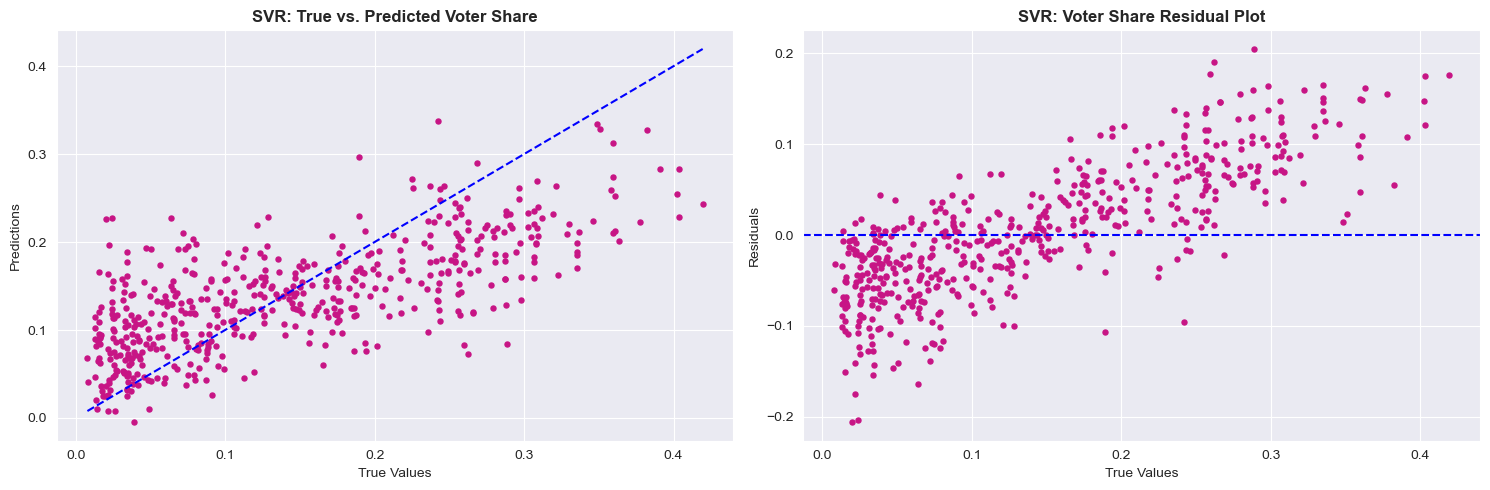

In [32]:
residplot('SVR', preds_svr)

## Elastic Net

In [33]:
pipe_el = Pipeline([
    ('sc', StandardScaler()),
    ('el', ElasticNet(random_state = 1527))
])

pipe_el.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('el', ElasticNet(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'el': ElasticNet(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'el__alpha': 1.0,
 'el__copy_X': True,
 'el__fit_intercept': True,
 'el__l1_ratio': 0.5,
 'el__max_iter': 1000,
 'el__positive': False,
 'el__precompute': False,
 'el__random_state': 1527,
 'el__selection': 'cyclic',
 'el__tol': 0.0001,
 'el__warm_start': False}

In [34]:
pgrid_el =[
    {'el__alpha': np.linspace(0.01, 10, 10), 
     'el__l1_ratio': np.linspace(0.001, 1, 20),
     'el__max_iter': [1000]
    }]

In [35]:
%%time

gs_el = GridSearchCV(pipe_el, pgrid_el, cv=5, n_jobs=10)
gs_el.fit(X_train, y_train)

CPU times: total: 1.53 s
Wall time: 10.7 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('el', ElasticNet(random_state=1527))]),
             n_jobs=10,
             param_grid=[{'el__alpha': array([ 0.01,  1.12,  2.23,  3.34,  4.45,  5.56,  6.67,  7.78,  8.89,
       10.  ]),
                          'el__l1_ratio': array([0.001     , 0.05357895, 0.10615789, 0.15873684, 0.21131579,
       0.26389474, 0.31647368, 0.36905263, 0.42163158, 0.47421053,
       0.52678947, 0.57936842, 0.63194737, 0.68452632, 0.73710526,
       0.78968421, 0.84226316, 0.89484211, 0.94742105, 1.        ]),
                          'el__max_iter': [1000]}])

In [36]:
preds_el = gs_el.predict(X_test)

In [37]:
print(f'-------------- {b1}Elastic Net w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_el.score(X_train, y_train),4)} --------------------')
print(f'------------------- Test: {round(gs_el.score(X_test, y_test),4)} ---------------------')
print(f'-------------------- RMSE: {round(mean_squared_error(y_test, preds_el, squared=False),4)} ---------------------')
print('Best Params:', gs_el.best_params_)

-------------- Elastic Net w/ GridSearch -------------
------------------- Train: 0.4702 --------------------
------------------- Test: 0.5234 ---------------------
-------------------- RMSE: 0.0702 ---------------------
Best Params: {'el__alpha': 0.01, 'el__l1_ratio': 0.001, 'el__max_iter': 1000}


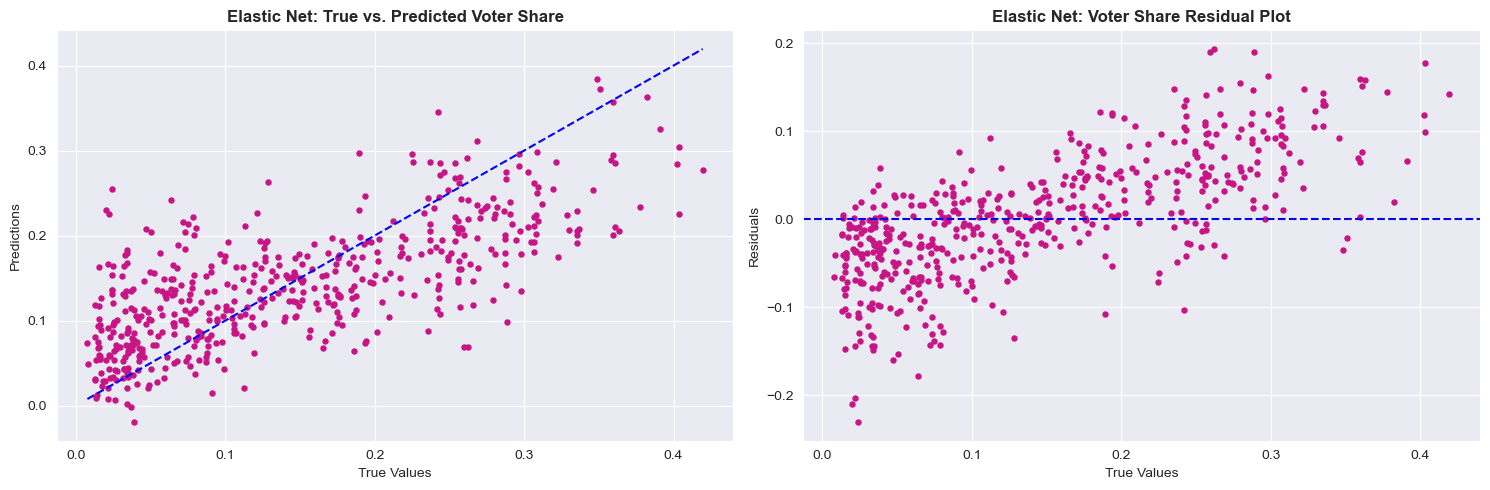

In [38]:
residplot('Elastic Net', preds_el)

In [39]:
best_el = gs_el.best_estimator_
feature_importances = best_el.named_steps['el'].coef_

In [40]:
feature_names = X_train.columns.tolist()

In [41]:
f1 = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
f1.sort_values(by=['feature_importance'], ascending=False,inplace=True)
f12 = f1.reset_index().drop(columns = ['index']).head(30)

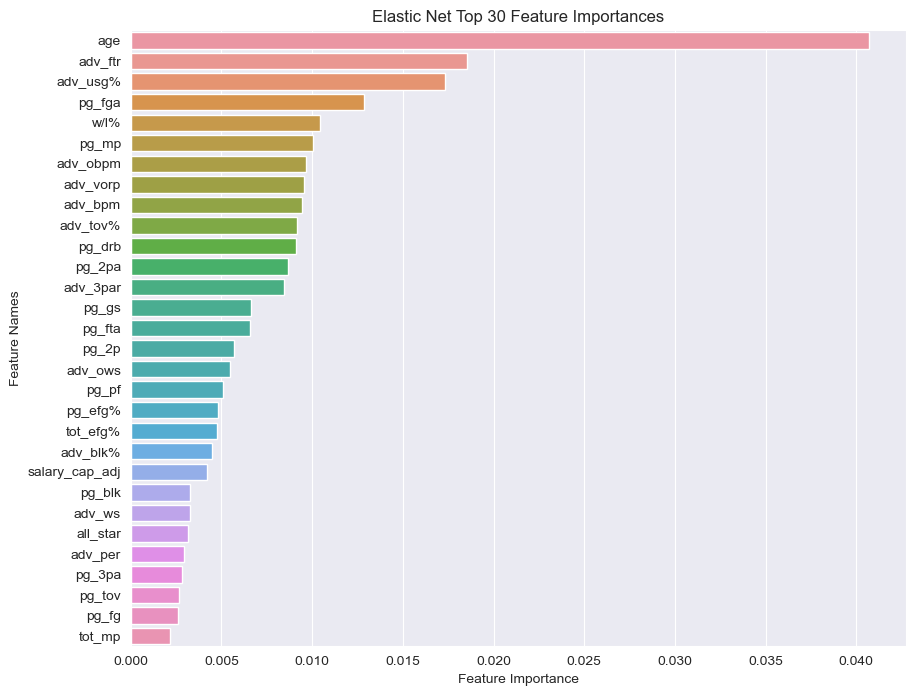

In [42]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=f12['feature_importance'], y=f12['feature_names'])
plt.title('Elastic Net Top 30 Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

#plt.savefig('../images/Feature_Importances_RF.png', dpi=192, bbox_inches='tight'); #Added

## Random Forest Regressor

In [43]:
pipe_rf = Pipeline([
    ('sc', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=1527))
])

pipe_rf.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('rf', RandomForestRegressor(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'rf': RandomForestRegressor(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'squared_error',
 'rf__max_depth': None,
 'rf__max_features': 1.0,
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 1527,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [44]:
pgrid_rf =[
    {'rf__n_estimators': [150, 200, 250],
     'rf__max_depth': [50, 70, 90],
     'rf__max_features': [3, 6, 10]
    }]

In [45]:
%%time

gs_rf = GridSearchCV(pipe_rf, pgrid_rf, cv=5, n_jobs=10)
gs_rf.fit(X_train, y_train)

CPU times: total: 1.8 s
Wall time: 1min 28s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=1527))]),
             n_jobs=10,
             param_grid=[{'rf__max_depth': [50, 70, 90],
                          'rf__max_features': [3, 6, 10],
                          'rf__n_estimators': [150, 200, 250]}])

In [46]:
preds_rf = gs_rf.predict(X_test)

In [47]:
print(f'------------- {b1}Random Forest w/ GridSearch{b0} ------------')
print(f'------------------- Train: {round(gs_rf.score(X_train, y_train),4)} --------------------')
print(f'------------------- Test: {round(gs_rf.score(X_test, y_test),4)} ---------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_rf, squared=False),4)} ---------------------')
print('Best Params:', gs_rf.best_params_)

------------- Random Forest w/ GridSearch ------------
------------------- Train: 0.9289 --------------------
------------------- Test: 0.5112 ---------------------
------------------- RMSE: 0.0711 ---------------------
Best Params: {'rf__max_depth': 50, 'rf__max_features': 10, 'rf__n_estimators': 250}


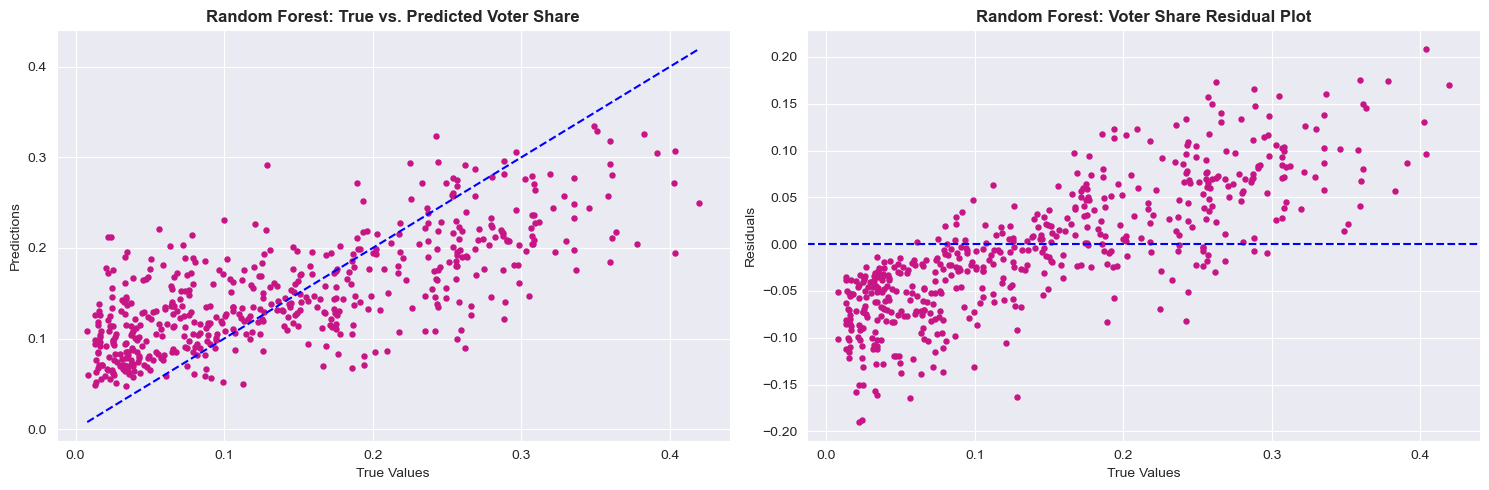

In [48]:
residplot('Random Forest', preds_rf)

In [49]:
best_estimator = gs_rf.best_estimator_
random_forest = best_estimator.named_steps['rf']
feature_importances = random_forest.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['age' 'g' 'pg_gs' 'pg_mp' 'pg_fg' 'pg_fga' 'pg_fg%' 'pg_3p' 'pg_3pa'
 'pg_3p%' 'pg_2p' 'pg_2pa' 'pg_2p%' 'pg_efg%' 'pg_ft' 'pg_fta' 'pg_ft%'
 'pg_orb' 'pg_drb' 'pg_trb' 'pg_ast' 'pg_stl' 'pg_blk' 'pg_tov' 'pg_pf'
 'pg_pts' 'tot_mp' 'tot_fg%' 'tot_3p' 'tot_3p%' 'tot_2p%' 'tot_efg%'
 'tot_ft%' 'tot_pf' 'tot_pts' 'adv_per' 'adv_ts%' 'adv_3par' 'adv_ftr'
 'adv_orb%' 'adv_drb%' 'adv_trb%' 'adv_ast%' 'adv_stl%' 'adv_blk%'
 'adv_tov%' 'adv_usg%' 'adv_ows' 'adv_dws' 'adv_ws' 'adv_ws/48' 'adv_obpm'
 'adv_dbpm' 'adv_bpm' 'adv_vorp' 'w/l%' 'seed' 'all_star' 'pos5_PG'
 'pos5_SG' 'pos5_SF' 'pos5_PF' 'year' 'salary_cap_adj']
[0.11398428 0.01072198 0.01054344 0.01208892 0.02986467 0.02358388
 0.01026228 0.00523458 0.00754008 0.00788383 0.02679575 0.02304227
 0.00929929 0.00829701 0.01050524 0.01506602 0.01157743 0.0082548
 0.0264203  0.01871322 0.01076751 0.00865065 0.01492441 0.01390817
 0.01004813 0.03725498 0.01257416 0.008934   0.00779221 0.00808224
 0.0094794  0.0091329  0.01120584 0.01554213 0

In [50]:
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

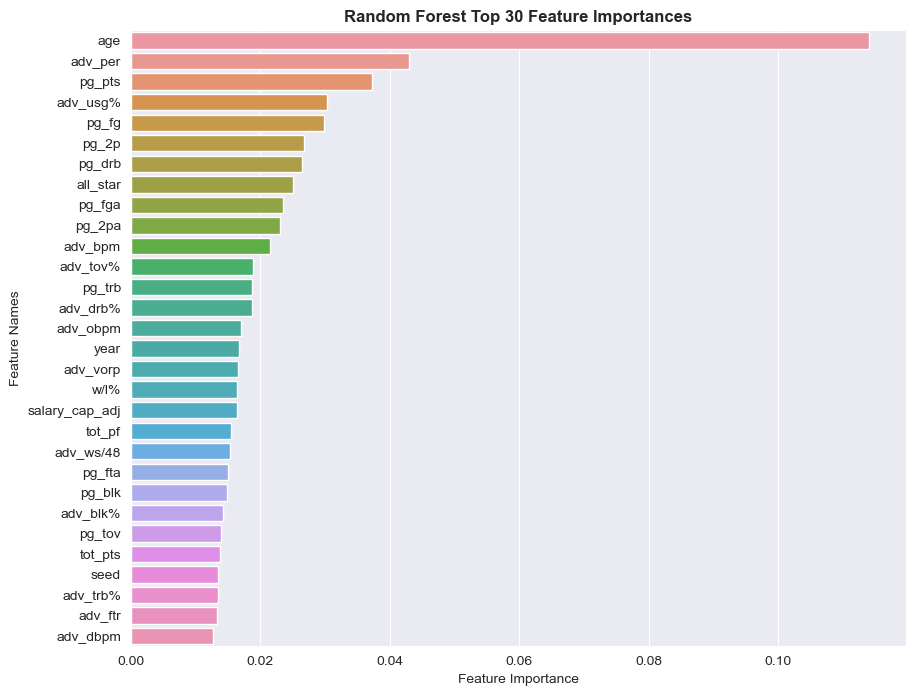

In [51]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('Random Forest Top 30 Feature Importances', fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

#plt.savefig('../images/Feature_Importances_RF.png', dpi=192, bbox_inches='tight'); 

## AdaBoost Regressor

In [52]:
pipe_ada = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('ada', AdaBoostRegressor(random_state=1527))
])

pipe_ada.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('ada', AdaBoostRegressor(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'ada': AdaBoostRegressor(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'ada__base_estimator': 'deprecated',
 'ada__estimator': None,
 'ada__learning_rate': 1.0,
 'ada__loss': 'linear',
 'ada__n_estimators': 50,
 'ada__random_state': 1527}

In [53]:
pgrid_ada = [{
     'ada__n_estimators': [70],
     'ada__learning_rate': np.linspace(0.01, .5, 15)
    }]

In [54]:
%%time

gs_ada = GridSearchCV(pipe_ada, pgrid_ada, cv=5, n_jobs=5)
gs_ada.fit(X_train, y_train)

CPU times: total: 609 ms
Wall time: 33.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ada',
                                        AdaBoostRegressor(random_state=1527))]),
             n_jobs=5,
             param_grid=[{'ada__learning_rate': array([0.01 , 0.045, 0.08 , 0.115, 0.15 , 0.185, 0.22 , 0.255, 0.29 ,
       0.325, 0.36 , 0.395, 0.43 , 0.465, 0.5  ]),
                          'ada__n_estimators': [70]}])

In [55]:
preds_ada = gs_ada.predict(X_test)

In [56]:
print(f'------------- {b1}AdaBoost w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_ada.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_ada.score(X_test, y_test),4)} --------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_ada, squared=False),4)} --------------------')
print('Best Params:', gs_ada.best_params_)

------------- AdaBoost w/ GridSearch -------------
------------------- Train: 0.4464 -------------------
------------------- Test: 0.4494 --------------------
------------------- RMSE: 0.0754 --------------------
Best Params: {'ada__learning_rate': 0.045, 'ada__n_estimators': 70}


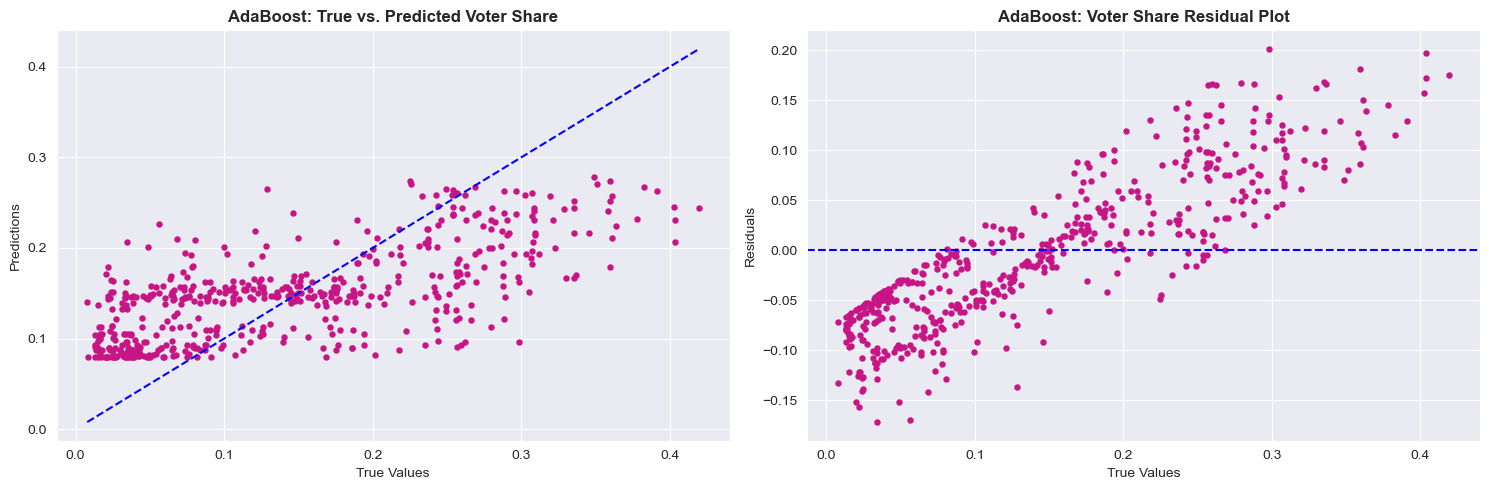

In [57]:
residplot('AdaBoost', preds_ada)

In [58]:
best_estimator = gs_ada.best_estimator_
adaboost = best_estimator.named_steps['ada']
feature_importances = adaboost.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['age' 'g' 'pg_gs' 'pg_mp' 'pg_fg' 'pg_fga' 'pg_fg%' 'pg_3p' 'pg_3pa'
 'pg_3p%' 'pg_2p' 'pg_2pa' 'pg_2p%' 'pg_efg%' 'pg_ft' 'pg_fta' 'pg_ft%'
 'pg_orb' 'pg_drb' 'pg_trb' 'pg_ast' 'pg_stl' 'pg_blk' 'pg_tov' 'pg_pf'
 'pg_pts' 'tot_mp' 'tot_fg%' 'tot_3p' 'tot_3p%' 'tot_2p%' 'tot_efg%'
 'tot_ft%' 'tot_pf' 'tot_pts' 'adv_per' 'adv_ts%' 'adv_3par' 'adv_ftr'
 'adv_orb%' 'adv_drb%' 'adv_trb%' 'adv_ast%' 'adv_stl%' 'adv_blk%'
 'adv_tov%' 'adv_usg%' 'adv_ows' 'adv_dws' 'adv_ws' 'adv_ws/48' 'adv_obpm'
 'adv_dbpm' 'adv_bpm' 'adv_vorp' 'w/l%' 'seed' 'all_star' 'pos5_PG'
 'pos5_SG' 'pos5_SF' 'pos5_PF' 'year' 'salary_cap_adj']
[0.27754302 0.00352152 0.         0.00380183 0.04382983 0.02406561
 0.00212652 0.         0.         0.         0.10181056 0.07988771
 0.         0.         0.00060011 0.00520487 0.0014646  0.00072028
 0.04523757 0.00090184 0.00112868 0.         0.01956171 0.00837596
 0.00442638 0.03541461 0.00112395 0.00359347 0.         0.
 0.         0.00164205 0.00171012 0.00285713 0.005062

In [59]:
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

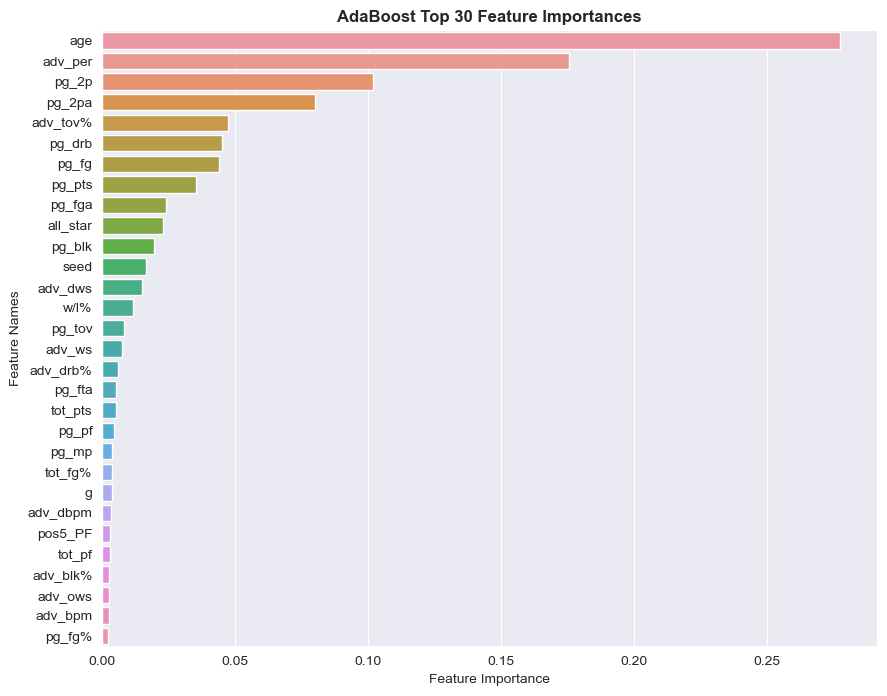

In [60]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('AdaBoost Top 30 Feature Importances', fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

# plt.savefig('../images/Feature_Importances_ada.png', dpi=192, bbox_inches='tight'); 

## XGBoost Regressor

In [62]:
pipe_xgb = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('xgb', XGBRegressor(random_state=1527))
])

pipe_xgb.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('xgb',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=1527, ...))],
 'verbose': False,
 'sc': StandardScaler(),
 'xgb': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample

In [63]:
# pgrid_xgb = [{
    # 'xgb__n_estimators': [50, 75, 100, 200],
    # 'xgb__max_depth': [3,4,5,6],
    # 'xgb__learning_rate': np.linspace(0.01, .5, 10),
    # 'xgb__reg_alpha': np.linspace(0.01, .5, 10)  
  #  }]

pgrid_xgb = [{
     'xgb__n_estimators': [200],
     'xgb__max_depth': [3],
     'xgb__learning_rate': [0.06444444444444444],
     'xgb__reg_alpha': [0.44555555555555554],
    }]

In [64]:
%%time

gs_xgb = GridSearchCV(pipe_xgb, pgrid_xgb, cv=5, n_jobs=10)
gs_xgb.fit(X_train, y_train)

CPU times: total: 2.22 s
Wall time: 5.11 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     in...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=1527, ...))]),
             n_jobs=10,
             param_grid=[{'xgb__learning_rate': [0.06444444444444444],
                          'xgb__max_depth': [3], 'xgb__n_estimators': [200],
                          'xgb__reg_alpha': [0.44555555555555554]}])

In [65]:
preds_xgb = gs_xgb.predict(X_test)

In [66]:
print(f'----------------- {b1}XGB w/ GridSearch{b0} -----------------')
print(f'------------------- Train: {round(gs_xgb.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_xgb.score(X_test, y_test),4)} --------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_xgb, squared=False),4)} --------------------')
print('Best Params:', gs_xgb.best_params_)

----------------- XGB w/ GridSearch -----------------
------------------- Train: 0.6632 -------------------
------------------- Test: 0.5772 --------------------
------------------- RMSE: 0.0661 --------------------
Best Params: {'xgb__learning_rate': 0.06444444444444444, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__reg_alpha': 0.44555555555555554}


In [ ]:
# 57% accuracy -- Best Params: {'xgb__colsample_bytree': None, 'xgb__learning_rate': 0.11888888888888888, 'xgb__max_depth': 3, 'xgb__n_estimators': 65, 'xgb__reg_alpha': 0.15, 'xgb__subsample': None}

In [ ]:
# 0.5772 - Best Params: {'xgb__colsample_bytree': None, 'xgb__learning_rate': 0.06444444444444444, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__reg_alpha': 0.44555555555555554, 'xgb__subsample': None}

In [75]:
nba_players_draft_info = {
    'Danny Schayes': {'Year Drafted': 1981, 'Overall Pick': 13},
    'Terry Davis': {'Year Drafted': 1989, 'Overall Pick': 45},
    'Moses Malone': {'Year Drafted': 1974, 'Overall Pick': 5},
    'Larry Stewart': {'Year Drafted': 1991, 'Overall Pick': 25},
    'Avery Johnson': {'Year Drafted': 1988, 'Overall Pick': 1000},
    'Clarence Weatherspoon': {'Year Drafted': 1992, 'Overall Pick': 9},
    'Robert Pack': {'Year Drafted': 1991, 'Overall Pick': 1000},
    'David Wesley': {'Year Drafted': 1990, 'Overall Pick': 1000},
    'Chris Childs': {'Year Drafted': 1995, 'Overall Pick': 1000},
    'John Starks': {'Year Drafted': 1988, 'Overall Pick': 1000},
    'Matt Maloney': {'Year Drafted': 1996, 'Overall Pick': 1000},
    'Bo Outlaw': {'Year Drafted': 1993, 'Overall Pick': 1000},
    'Isaac Austin': {'Year Drafted': 1991, 'Overall Pick': 1000},
    'Darrick Martin': {'Year Drafted': 1994, 'Overall Pick': 1000},
    'Tyrone Nesby': {'Year Drafted': 1998, 'Overall Pick': 1000},
    'Erick Strickland': {'Year Drafted': 1996, 'Overall Pick': 19},
    'Darrell Armstrong': {'Year Drafted': 1991, 'Overall Pick': 1000},
    'Chucky Atkins': {'Year Drafted': 1999, 'Overall Pick': 1000},
    'Brad Miller': {'Year Drafted': 1998, 'Overall Pick': 1000},
    'Ira Newble': {'Year Drafted': 1997, 'Overall Pick': 1000},
    'Troy Hudson': {'Year Drafted': 1997, 'Overall Pick': 1000},
    'Carlos Arroyo': {'Year Drafted': 2001, 'Overall Pick': 1000},
    'Mike James': {'Year Drafted': 1998, 'Overall Pick': 1000},
    'Raja Bell': {'Year Drafted': 1999, 'Overall Pick': 1000},
    'Earl Boykins': {'Year Drafted': 1999, 'Overall Pick': 1000},
    'Udonis Haslem': {'Year Drafted': 2002, 'Overall Pick': 1000},
    'Damon Jones': {'Year Drafted': 1997, 'Overall Pick': 1000},
    'Marquis Daniels': {'Year Drafted': 2003, 'Overall Pick': 1000},
    'Ronald Murray': {'Year Drafted': 2002, 'Overall Pick': 1000},
    'Andres Nocioni': {'Year Drafted': 1999, 'Overall Pick': 1000},
    'Smush Parker': {'Year Drafted': 2002, 'Overall Pick': 1000},
    'Charlie Bell': {'Year Drafted': 2001, 'Overall Pick': 1000},
    'Devin Brown': {'Year Drafted': 2002, 'Overall Pick': 1000},
    'Matt Carroll': {'Year Drafted': 2003, 'Overall Pick': 1000},
    'Jorge Garbajosa': {'Year Drafted': 2006, 'Overall Pick': 1000},
    'Ime Udoka': {'Year Drafted': 2000, 'Overall Pick': 1000},
    'Jose Calderon': {'Year Drafted': 2005, 'Overall Pick': 1000},
    'Anthony Carter': {'Year Drafted': 1998, 'Overall Pick': 1000},
    'Chuck Hayes': {'Year Drafted': 2005, 'Overall Pick': 1000},
    'J.J. Hickson': {'Year Drafted': 2008, 'Overall Pick': 19},
    'Wesley Matthews': {'Year Drafted': 2009, 'Overall Pick': 1000},
    'Anthony Morrow': {'Year Drafted': 2008, 'Overall Pick': 1000},
    'Alonzo Gee': {'Year Drafted': 2009, 'Overall Pick': 1000},
    'J.J. Redick': {'Year Drafted': 2006, 'Overall Pick': 11},
    'Jeremy Lin': {'Year Drafted': 2010, 'Overall Pick': 1000},
    'J.R. Smith': {'Year Drafted': 2004, 'Overall Pick': 18},
    'Omer Asik': {'Year Drafted': 2008, 'Overall Pick': 36},
    'Robert Covington': {'Year Drafted': 2013, 'Overall Pick': 1000},
    'Langston Galloway': {'Year Drafted': 2014, 'Overall Pick': 1000},
    'C.J. Miles': {'Year Drafted': 2005, 'Overall Pick': 34},
    'Kent Bazemore': {'Year Drafted': 2012, 'Overall Pick': 1000},
    'Seth Curry': {'Year Drafted': 2013, 'Overall Pick': 1000},
    'Yogi Ferrell': {'Year Drafted': 2016, 'Overall Pick': 1000},
    'JaMychal Green': {'Year Drafted': 2015, 'Overall Pick': 1000},
    'T.J. McConnell': {'Year Drafted': 2015, 'Overall Pick': 1000},
    'Garrett Temple': {'Year Drafted': 2009, 'Overall Pick': 1000},
    'Jeremy Lin': {'Year Drafted': 2010, 'Overall Pick': 1000},
    'JaMychal Green': {'Year Drafted': 2015, 'Overall Pick': 1000},
    'Joe Ingles': {'Year Drafted': 2014, 'Overall Pick': 1000},
    'Tyler Johnson': {'Year Drafted': 2014, 'Overall Pick': 1000},
    'Wesley Matthews': {'Year Drafted': 2009, 'Overall Pick': 1000},
    'Marcus Morris': {'Year Drafted': 2011, 'Overall Pick': 14},
    'J.J. Redick': {'Year Drafted': 2006, 'Overall Pick': 11},
    'Jonathon Simmons': {'Year Drafted': 2015, 'Overall Pick': 1000},
    'Bryn Forbes': {'Year Drafted': 2016, 'Overall Pick': 1000},
    'Fred VanVleet': {'Year Drafted': 2016, 'Overall Pick': 1000},
    'OG Anunoby': {'Year Drafted': 2017, 'Overall Pick': 1000},
    'Robert Covington': {'Year Drafted': 2013, 'Overall Pick': 1000},
    'Dorian Finney-Smith': {'Year Drafted': 2016, 'Overall Pick': 1000},
    'Danuel House Jr.': {'Year Drafted': 2016, 'Overall Pick': 1000},
    'Damion Lee': {'Year Drafted': 2016, 'Overall Pick': 1000},
    'Kendrick Nunn': {'Year Drafted': 2018, 'Overall Pick': 1000},
    'Duncan Robinson': {'Year Drafted': 2018, 'Overall Pick': 1000},
    'Ish Smith': {'Year Drafted': 2010, 'Overall Pick': 1000},
    "Jae'Sean Tate": {'Year Drafted': 2018, 'Overall Pick': 1000},
    'Christian Wood': {'Year Drafted': 2015, 'Overall Pick': 1000},
    'Alex Caruso': {'Year Drafted': 2016, 'Overall Pick': 1000},
    'Seth Curry': {'Year Drafted': 2013, 'Overall Pick': 1000},
    'Luguentz Dort': {'Year Drafted': 2020, 'Overall Pick': 1000},
    'Caleb Martin': {'Year Drafted': 2019, 'Overall Pick': 1000},
    'Austin Reaves': {'Year Drafted': 2021, 'Overall Pick': 1000},
    'John Starks': {'Year Drafted': 1988, 'Overall Pick': 1000},
    'Clarence Weatherspoon': {'Year Drafted': 1992, 'Overall Pick': 1000},
    'Avery Johnson': {'Year Drafted': 1988, 'Overall Pick': 1000},
    'Bo Outlaw': {'Year Drafted': 1993, 'Overall Pick': 1000},
    'Darrell Armstrong': {'Year Drafted': 1991, 'Overall Pick': 1000},
    'Ben Wallace': {'Year Drafted': 1996, 'Overall Pick': 1000},
    'Brad Miller': {'Year Drafted': 1998, 'Overall Pick': 1000},
    'Omer Asik': {'Year Drafted': 2008, 'Overall Pick': 36},
    'J.J. Hickson': {'Year Drafted': 2008, 'Overall Pick': 19}
}



In [76]:
chk = pd.DataFrame.from_dict(nba_players_draft_info, orient='index')
chk

,Year Drafted,Overall Pick
Danny Schayes,1981,13
Terry Davis,1989,45
Moses Malone,1974,5
Larry Stewart,1991,25
Avery Johnson,1988,1000
Clarence Weatherspoon,1992,1000
Robert Pack,1991,1000
David Wesley,1990,1000
Chris Childs,1995,1000
John Starks,1988,1000
